In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py

# import cortex
import numpy as np

# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from himalaya.scoring import correlation_score

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [51]:
modelname = "model-gpt2-2b_layer-24"
# modelname = "model-opt-7b_layer-23"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"
# encmodel = "encoding_trialmot6"
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding/trialmot6', 'trialmot6')

In [5]:
glasser = Atlas.glasser2016()
catlas = Atlas.load("custom_glasser")

In [6]:
lags = np.arange(-10, 11)

In [11]:
sub_mbc_scores = []
# mbc_scores = defaultdict(list)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        # prod_predA = f["cv_preds"][:, -2]
        # comp_predA = f["cv_preds"][:, -1]
        # prodmaskA = f["cv_prodmask"][...]
        predA = f["cv_preds"][:, -2:].sum(1)

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]
        nuis_predsB = Y_predsB[:, :-2].sum(1)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB.reshape(5, 240, -1) - nuis_predsB

    # per run
    n_folds = 5
    sub_scores = np.zeros((n_folds, len(lags), predA.shape[-1]), dtype=np.float32)
    for k in range(n_folds):
        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA[k, :lag]
                trialB = resB[k, -lag:]
            elif lag > 0:
                trialA = predA[k, lag:]
                trialB = resB[k, :-lag]
            else:
                trialA = predA[k]
                trialB = resB[k]

            sub_scores[k, i] = correlation_score(trialA, trialB)

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [58:52<00:00, 60.90s/it]


(58, 5, 21, 81924)

In [12]:
# save
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
!mkdir -p $outdir
with h5py.File(f"{outdir}/mbc-var1.hdf5", "w") as f:
    f.create_dataset(name="within", data=sub_mbc_prod)

In [13]:
avg_mbc_prod = sub_mbc_prod.mean((0, 1))
avg_mbc_prod.shape

(21, 81924)

In [14]:
list(zip(range(len(lags)), lags))

[(0, -10),
 (1, -9),
 (2, -8),
 (3, -7),
 (4, -6),
 (5, -5),
 (6, -4),
 (7, -3),
 (8, -2),
 (9, -1),
 (10, 0),
 (11, 1),
 (12, 2),
 (13, 3),
 (14, 4),
 (15, 5),
 (16, 6),
 (17, 7),
 (18, 8),
 (19, 9),
 (20, 10)]

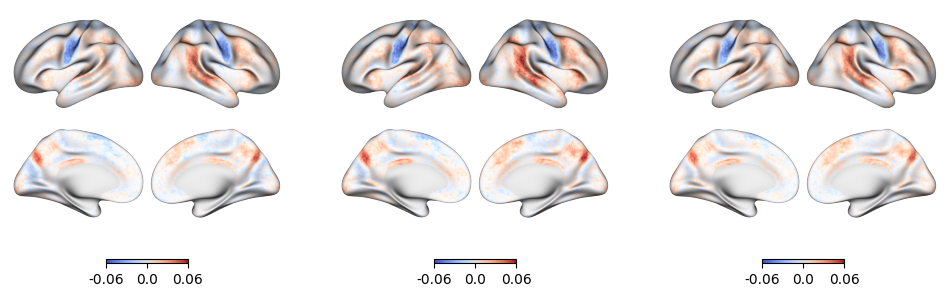

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
plot.surface_plot(avg_mbc_prod[9], cmap="coolwarm", fig=fig, ax=axes[0], vmax=0.06)
plot.surface_plot(avg_mbc_prod[10], cmap="coolwarm", fig=fig, ax=axes[1], vmax=0.06)
plot.surface_plot(avg_mbc_prod[11], cmap="coolwarm", fig=fig, ax=axes[2], vmax=0.06)
fig.show()

In [22]:
bestLags = np.abs(avg_mbc_prod).argmax(0)
bestLags.shape

(81924,)

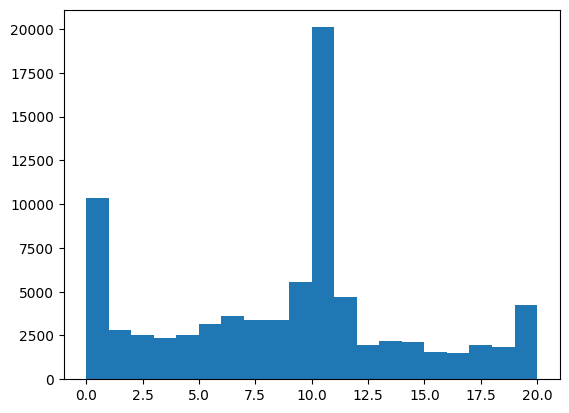

In [24]:
plt.hist(bestLags, bins=20)

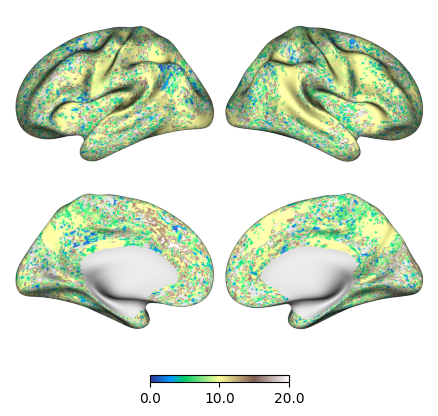

In [35]:
plot.surface_plot(bestLags, cmap="terrain", vmin=0)

In [31]:
atlas = Atlas.schaefer(networks=17, kong=True).to_network()
len(atlas)

34

In [33]:
atlas.labels

['LH_Aud',
 'LH_ContA',
 'LH_ContB',
 'LH_ContC',
 'LH_DefaultA',
 'LH_DefaultB',
 'LH_DefaultC',
 'LH_DorsAttnA',
 'LH_DorsAttnB',
 'LH_Language',
 'LH_SalVenAttnA',
 'LH_SalVenAttnB',
 'LH_SomMotA',
 'LH_SomMotB',
 'LH_VisualA',
 'LH_VisualB',
 'LH_VisualC',
 'RH_Aud',
 'RH_ContA',
 'RH_ContB',
 'RH_ContC',
 'RH_DefaultA',
 'RH_DefaultB',
 'RH_DefaultC',
 'RH_DorsAttnA',
 'RH_DorsAttnB',
 'RH_Language',
 'RH_SalVenAttnA',
 'RH_SalVenAttnB',
 'RH_SomMotA',
 'RH_SomMotB',
 'RH_VisualA',
 'RH_VisualB',
 'RH_VisualC']

In [34]:
atlas.vox_to_parc(bestLags)

array([ 9,  9,  8, 10,  9,  9,  8,  9,  9,  9,  9,  9,  9,  9,  9,  8,  9,
        9,  8,  9,  9,  9,  9,  9,  8,  8,  9,  9,  9,  8,  9,  9,  9,  9])

# ISC prod-comp

1. get subA bold data
1. get subB bold data
1. for each run (out of 5), find when subA is speaking
1. then, for each lag, shift the bold data accordingly
1. then, select only TRs when subA is speaking
1. then compute a correlation between boldA and boldB

if you first select TRs then shift, you will be spilling over data across utterances

In [ ]:
sub_mbc_scores = []

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA
    boldA = subject.get_bold(subA, use_cache=True, cache_desc=cache)
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prodmaskA = f["cv_prodmask"][...]

    # load subB
    subB = subject.get_partner(subA)
    boldB = subject.get_bold(subB, use_cache=True, cache_desc=cache)

    boldA = boldA.reshape(5, 240, -1)
    boldB = boldB.reshape(5, 240, -1)

    # per run
    n_folds = 5
    sub_scores = np.zeros((n_folds, len(lags), boldA.shape[-1]), dtype=np.float32)
    for k in range(n_folds):
        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = boldA[k][:lag]
                trialB = boldB[k][-lag:]
                trialM = prodmaskA[k][:lag]
            elif lag > 0:
                trialA = boldA[k][lag:]
                trialB = boldB[k][:-lag]
                trialM = prodmaskA[k][lag:]
            else:
                trialA = boldA[k]
                trialB = boldB[k]
                trialM = prodmaskA[k]

            sub_scores[k, i] = correlation_score(trialA[trialM], trialB[trialM])

    sub_mbc_scores.append(sub_scores)

sub_mbc_scores = np.stack(sub_mbc_scores)
avg_mbc_scores = sub_mbc_scores.mean((0, 1))

avg_mbc_scores.shape

In [ ]:
# save
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
!mkdir -p $outdir
with h5py.File(f"{outdir}/isc-prod-comp.hdf5", "w") as f:
    f.create_dataset(name="comp", data=sub_mbc_scores)

In [ ]:
# # load
# outdir = f'cache/{modelname}/{cache}'
# with h5py.File(f"{outdir}/mbc_scores.hdf5", "r") as f:
#     sub_mbc_prod = f["prod"][...]
#     sub_mbc_comp = f["comp"][...]
# sub_mbc_prod.shape

In [ ]:
plot_lags = [8, 9, 10, 11]
fig, axes = plt.subplots(1, 4, figsize=(14, 5), dpi=120)
for lag, ax in zip(plot_lags, axes):
    plot.surface_plot(
        avg_mbc_scores[lag], fig=fig, ax=ax, title=f"lag {1.5 * lags[lag]}s", vmax=0.1
    )
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(lags * 1.5, np.mean(avg_mbc_scores, axis=-1), marker=".")
ax.set(xlabel="lag (s)", ylabel="ISC (r)")
ax.axvline(0, c="k", ls="--", alpha=0.2)
ax.axhline(0, c="k", ls="--", alpha=0.2)
ax.text(
    0.25,
    1,
    "speaker precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)
ax.text(
    0.75,
    1,
    "listener precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)
fig.show()

In [ ]:
avg_mbc_parc = catlas.vox_to_parc(avg_mbc_scores)
avg_mbc_parc.shape

In [ ]:
list(zip(catlas.labels, avg_mbc_parc.max(0), 1.5 * lags[avg_mbc_parc.argmax(0)]))

In [ ]:
rois = ["AUD_EAC", "Lang_STG", "Lang_aSTS", "Lang_pSTS"]
# rois = ["MOT_M1", "MOT_S1", "MOT_INS"]
# rois = ["Lang_MFG", "Lang_IFJ", "Lang_IFG"]
# rois = ["Lang_pTemp", "Lang_SMG"]
# rois = ["Lang_SFL1", "Lang_SFL2"]
# rois = ["DMN_PCC1", "DMN_PCC3", "DMN_SPC1"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for roi in rois:
    # NOTE the - 1
    axes[0].plot(
        lags * 1.5, avg_mbc_parc[:, catlas[f"LH_{roi}"] - 1], label=roi.split("_")[-1]
    )
    axes[1].plot(
        lags * 1.5, avg_mbc_parc[:, catlas[f"RH_{roi}"] - 1], label=roi.split("_")[-1]
    )
for ax in axes:
    ax.axvline(0, c="k", ls="--", alpha=0.2)
    ax.axhline(0, c="k", ls="--", alpha=0.2)
    ax.text(
        0.25,
        1,
        "speaker precedes",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="center",
    )
    ax.text(
        0.75,
        1,
        "listener precedes",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="center",
    )
axes[0].set_title("LH")
axes[1].set_title("RH")
axes[1].legend(loc="lower left")
fig.show()

In [ ]:
values = 1.5 * lags[avg_mbc_scores.argmax(0)]
fig, ax = plt.subplots()
plot.surface_plot(values, fig=fig, ax=ax, zeroNan=True)
fig.show()

In [ ]:
atlas = glasser

avg_mbc_parc = atlas.vox_to_parc(avg_mbc_scores)
best_lags_parc = 1.5 * lags[avg_mbc_parc.argmax(0)]
values = atlas.parc_to_vox(best_lags_parc)
fig, ax = plt.subplots()
plot.surface_plot(values, fig=fig, ax=ax, zeroNan=False)
fig.show()

# model-weight similarity

## calculate

In [52]:
modelname

'model-gpt2-2b_layer-24'

In [55]:
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root="encoding_trialmot6",
    sub="000",
    datatype=modelname,
    desc="folds-2",
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prodA = f["cv_weights_prod"][0, ...]
        weights_compA = f["cv_weights_comp"][0, ...]

    subB = subject.get_partner(sub)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        weights_prodB = f["cv_weights_prod"][1, ...]
        weights_compB = f["cv_weights_comp"][1, ...]

    # weight_sim_within.append(correlation_score(weights_prodA, weights_compA))
    # weight_sim_within.append(correlation_score(weights_prodB, weights_compB))

    weight_sim_between.append(correlation_score(weights_prodA, weights_compB))
    weight_sim_between.append(correlation_score(weights_prodB, weights_compA))

# weight_sim_within = np.stack(weight_sim_within)
weight_sim_between = np.stack(weight_sim_between)
# weight_sim_within.shape

100%|██████████| 58/58 [07:52<00:00,  8.15s/it]


In [56]:
# save
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
!mkdir -p $outdir
with h5py.File(f"{outdir}/wbc-within-between.hdf5", "w") as f:
    # f.create_dataset(name="within", data=weight_sim_within)
    f.create_dataset(name="between", data=weight_sim_between)

In [15]:
# save
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
with h5py.File(f"{outdir}/wbc-within-between.hdf5", "r") as f:
    weight_sim_within = f["within"][...]
    weight_sim_between = f["between"][...]
weight_sim_between.shape

(58, 81924)

In [59]:
len(SUBS_STRANGERS) * 2

116

## plot

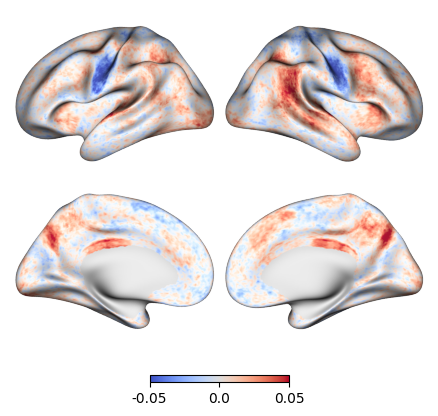

In [61]:
values = weight_sim_between.mean(0)
fig = plot.surface_plot(values, cmap="coolwarm")

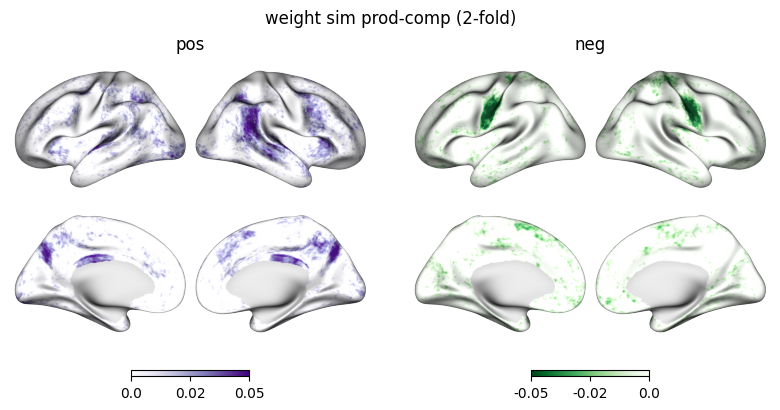

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
plot.surface_plot(
    values, cmap="Purples", vmin=0, vmax=0.05, fig=fig, ax=axes[0], title="pos"
)
plot.surface_plot(
    values, cmap="Greens_r", vmin=-0.05, vmax=0, fig=fig, ax=axes[1], title="neg"
)
fig.suptitle("weight sim prod-comp (2-fold)")
fig.show()

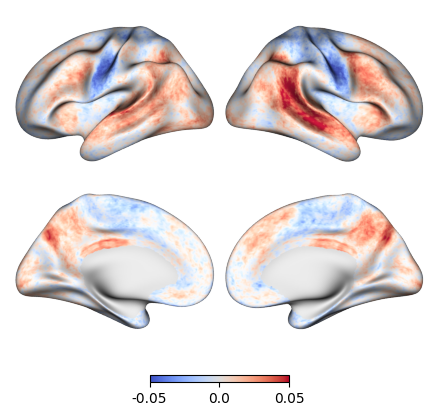

In [7]:
values = weight_sim_within.mean(0)
fig = plot.surface_plot(values, cmap="coolwarm")

# MBC

## calculate

In [ ]:
sub_mbc_scores = []
# mbc_scores = defaultdict(list)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_predA = f["cv_preds"][:, -2]
        # comp_predA = f["cv_preds"][:, -1]
        prodmaskA = f["cv_prodmask"][...]

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]
        nuis_predsB = Y_predsB[:, :-2].sum(1)

    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB.reshape(5, 240, -1) - nuis_predsB

    # per run
    n_folds = 5
    sub_scores = np.zeros((n_folds, len(lags), boldA.shape[-1]), dtype=np.float32)
    for k in range(n_folds):
        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = prod_predA[k][:lag]
                trialB = resB[k][-lag:]
                trialM = prodmaskA[k][:lag]
            elif lag > 0:
                trialA = prod_predA[k][lag:]
                trialB = resB[k][:-lag]
                trialM = prodmaskA[k][lag:]
            else:
                trialA = prod_predA[k]
                trialB = resB[k]
                trialM = prodmaskA[k]

            sub_scores[k, i] = correlation_score(trialA[trialM], trialB[trialM])

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

In [ ]:
# save
outdir = f"cache/{modelname}/{cache}/figure-mbc/"
!mkdir -p $outdir
with h5py.File(f"{outdir}/mbc-lags.hdf5", "w") as f:
    f.create_dataset(name="prod", data=sub_mbc_scores)

In [7]:
outdir = f"cache/{modelname}/{cache}/figure-mbc"
with h5py.File(f"{outdir}/mbc-lags.hdf5", "r") as f:
    sub_mbc_prod = f["prod"][...]
sub_mbc_prod.shape

(58, 5, 21, 81924)

In [8]:
avg_mbc_prod = sub_mbc_prod.mean((0, 1))

# mbc brain map at lag 0

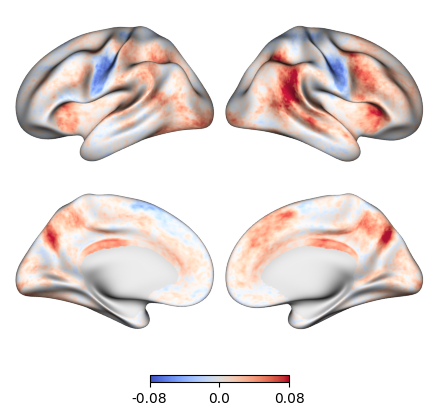

In [9]:
values = avg_mbc_prod[10]
# values[~sigmask] = 0

# values = np.where(prod_sigmask | comp_sigmask, values, 0)
fig = plot.surface_plot(values, cmap="coolwarm")

## whole-brain cross-correlation

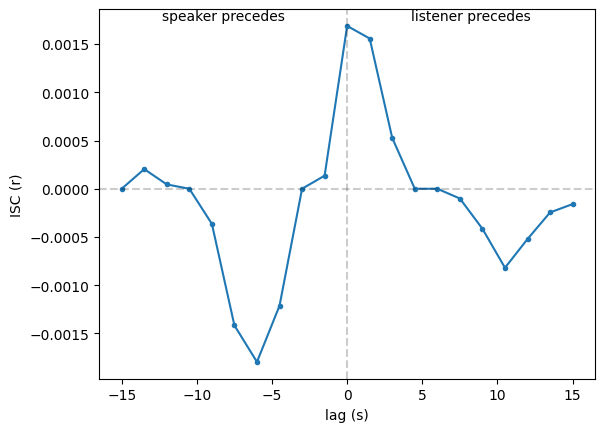

In [21]:
fig, ax = plt.subplots()
ax.plot(lags * 1.5, np.median(avg_mbc_prod, axis=-1), marker=".")
ax.set(xlabel="lag (s)", ylabel="ISC (r)")
ax.axvline(0, c="k", ls="--", alpha=0.2)
ax.axhline(0, c="k", ls="--", alpha=0.2)
ax.text(
    0.25,
    1,
    "speaker precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)
ax.text(
    0.75,
    1,
    "listener precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)
fig.show()

## ROI cross-correlation

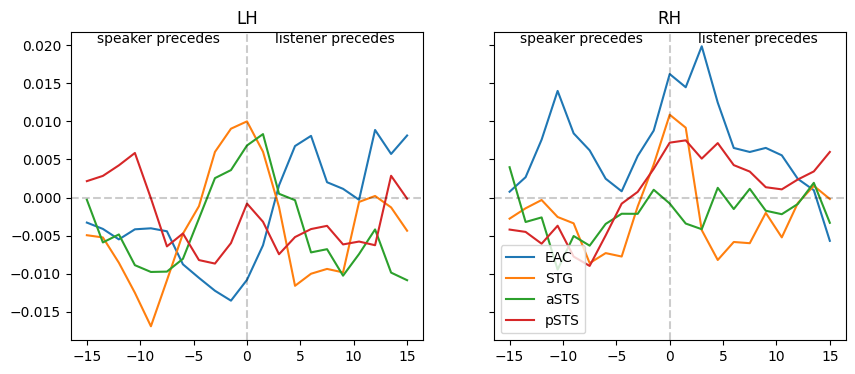

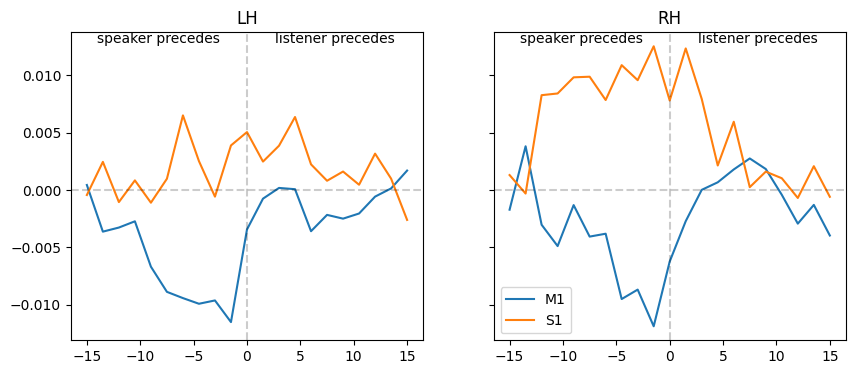

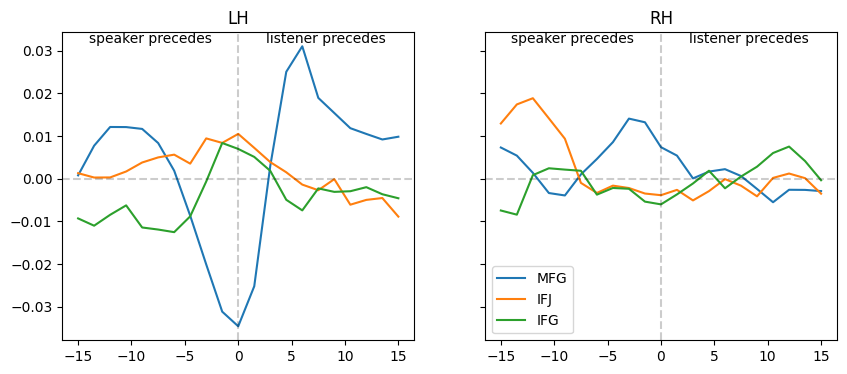

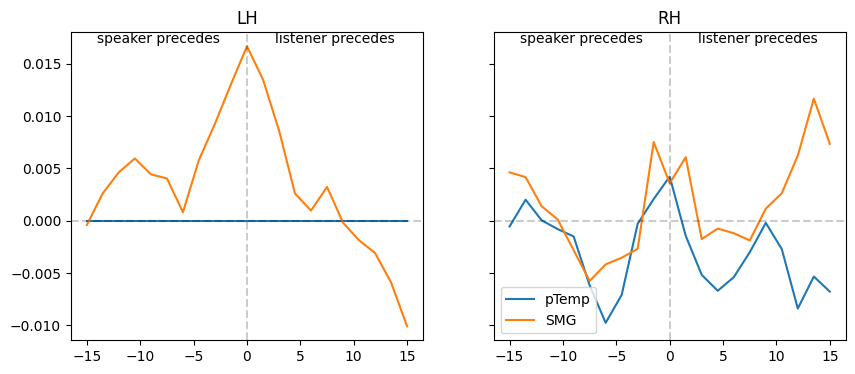

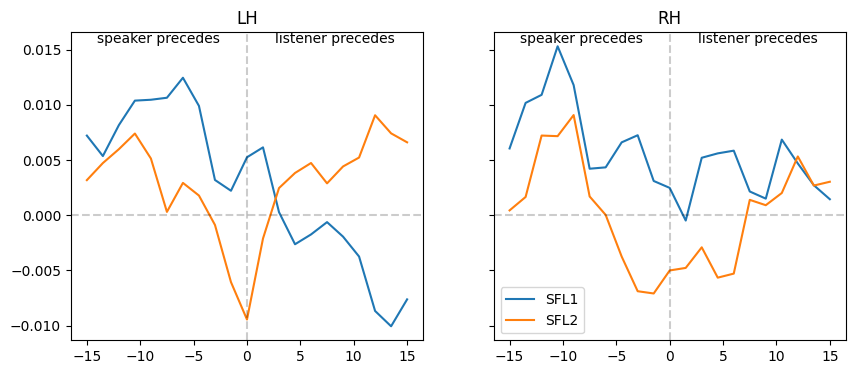

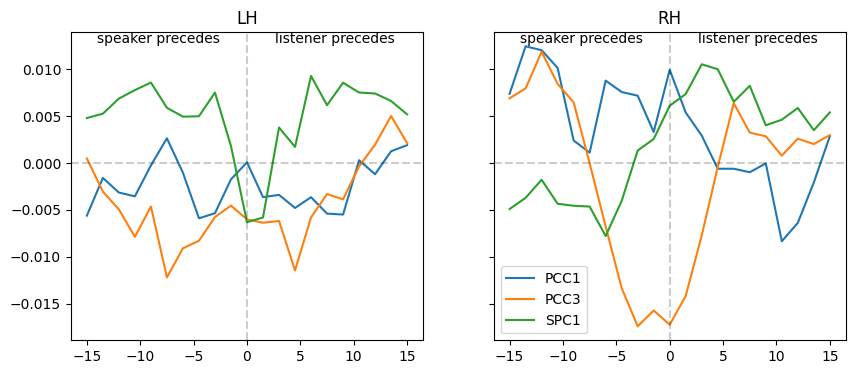

In [17]:
groups = [
    ["AUD_EAC", "Lang_STG", "Lang_aSTS", "Lang_pSTS"],
    ["MOT_M1", "MOT_S1"],
    ["Lang_MFG", "Lang_IFJ", "Lang_IFG"],
    ["Lang_pTemp", "Lang_SMG"],
    ["Lang_SFL1", "Lang_SFL2"],
    ["DMN_PCC1", "DMN_PCC3", "DMN_SPC1"],
]

for rois in groups:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
    for roi in rois:
        # NOTE the - 1
        axes[0].plot(
            lags * 1.5,
            avg_mbc_prod[:, catlas[f"LH_{roi}"] - 1],
            label=roi.split("_")[-1],
        )
        axes[1].plot(
            lags * 1.5,
            avg_mbc_prod[:, catlas[f"RH_{roi}"] - 1],
            label=roi.split("_")[-1],
        )
    for ax in axes:
        ax.axvline(0, c="k", ls="--", alpha=0.2)
        ax.axhline(0, c="k", ls="--", alpha=0.2)
        ax.text(
            0.25,
            1,
            "speaker precedes",
            transform=ax.transAxes,
            verticalalignment="top",
            horizontalalignment="center",
        )
        ax.text(
            0.75,
            1,
            "listener precedes",
            transform=ax.transAxes,
            verticalalignment="top",
            horizontalalignment="center",
        )
    axes[0].set_title("LH")
    axes[1].set_title("RH")
    axes[1].legend(loc="lower left")
    fig.show()